# **DataFest Africa Noise Pollution Classification Challenge**

Due to the widespread noise pollution in our cities, Sunbird AI recognised a need to gather data on noise exposure in order to produce an action plan and empower citizens to be vigilant in tracking and monitoring noise.

This process was carried out by collecting noise samples around Kampala using mobile phones with the Open Data Kit (ODK) data collection tool. Sunbird AI gathered a total of nineteen noise data categories collected from the six divisions of Kampala, and for each of the nineteen categories we collected an average of 2000 noise data points.

The challenge is to train a noise classification model to classify noise into noise categories

There are ~ 30 000 audio files in train and ~12 000 audio files in test.

 ##  **<span style='color:green'> Objective </span>**

The objective of this challenge is to train a noise classification model to classify noise into different categories.

##  **<span style='color:green'> The solution </span> 🧠**
This solution is based on the architechture of the well known model <a href="https://pytorch.org/hub/pytorch_vision_resnet/">Ressnet</a> and uses the technique of transfer learning to get some learned features form others tasks and use them in this contest to help our custom model to make accurate predictions.

The main framework used to implement the model is <a href="https://pytorch.org/get-started/locally/">Pytorch</a>.

# **SETUP**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install librosa -U --quiet
!pip install torchaudio --quiet

     |████████████████████████████████| 214 kB 5.1 MB/s 


# **Imports**

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
import os
import sys
import cv2
import glob
import math
import random
import librosa
import zipfile
import numpy as np
import pandas as pd
from librosa import display as libdisplay
from tqdm.notebook import tqdm

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms
from torchvision import models


In [ ]:
import IPython.display as ipd
from matplotlib import pyplot as plt

# **Unzip**

In [ ]:
!cp "/content/drive/MyDrive/Noise Classification" -r "/content/"

In [ ]:
!unzip '/content/Noise Classification/Audio_clips.zip'

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/AUDIO_CLIPS/._ID_3J5IK2HQ.wav  
  inflating: AUDIO_CLIPS/ID_P3PW2LKJ.wav  
  inflating: __MACOSX/AUDIO_CLIPS/._ID_P3PW2LKJ.wav  
  inflating: AUDIO_CLIPS/ID_C8L70KS8.wav  
  inflating: AUDIO_CLIPS/ID_LLUU1YNV.wav  
  inflating: __MACOSX/AUDIO_CLIPS/._ID_LLUU1YNV.wav  
  inflating: AUDIO_CLIPS/ID_I7ERU5AD.wav  
  inflating: __MACOSX/AUDIO_CLIPS/._ID_I7ERU5AD.wav  
  inflating: AUDIO_CLIPS/ID_1YCFOCGF.wav  
  inflating: __MACOSX/AUDIO_CLIPS/._ID_1YCFOCGF.wav  
  inflating: AUDIO_CLIPS/ID_6X207YNI.wav  
  inflating: __MACOSX/AUDIO_CLIPS/._ID_6X207YNI.wav  
  inflating: AUDIO_CLIPS/ID_6QNAWXW9.wav  
  inflating: __MACOSX/AUDIO_CLIPS/._ID_6QNAWXW9.wav  
  inflating: AUDIO_CLIPS/ID_EZDSCSU7.wav  
  inflating: __MACOSX/AUDIO_CLIPS/._ID_EZDSCSU7.wav  
  inflating: AUDIO_CLIPS/ID_0YJM6SH9.wav  
  inflating: __MACOSX/AUDIO_CLIPS/._ID_0YJM6SH9.wav  
  inflating: AUDIO_CLIPS/ID_PPBAS1LC.wav  
  inflating: __MACOSX/AUDIO_CLIPS

# **Envs**

In [ ]:
path = '/content/Noise Classification/'

In [ ]:
seed = 2020
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:

os.makedirs('/content/drive/MyDrive/NoiseClassificationChallenge/SPEC_IMAGES_TRAIN/', exist_ok=True)

In [ ]:
#Placeholder for the training and test spectogram's images
#It is going to store the spec, we will shortly generate.
os.makedirs('/content/drive/MyDrive/NoiseClassificationChallenge/MODELS/', exist_ok=True) #will store our models here
os.makedirs('/content/drive/MyDrive/NoiseClassificationChallenge/SPEC_IMAGES_TRAIN/', exist_ok=True)
os.makedirs('/content/drive/MyDrive/NoiseClassificationChallenge/SPEC_IMAGES_TEST/', exist_ok=True)
os.makedirs('/content/drive/MyDrive/NoiseClassificationChallenge/Final_DF/', exist_ok=True)

In [ ]:
os.makedirs('/content/drive/MyDrive/NoiseClassificationChallenge/Final_DF/', exist_ok=True)

# **Utilities**

In [ ]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [ ]:
def show_audio(ad):
    sig,sr = ad
    ipd.display(ipd.Audio(data=sig, rate=sr))

In [ ]:
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    idea from this post:
    http://www.kaggle.com/c/emc-data-science/forums/t/2149/is-anyone-noticing-difference-betwen-validation-and-leaderboard-error/12209#post12209

    Parameters
    ----------
    y_true : array, shape = [n_samples]
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(predictions))
    return -1.0 / rows * vsota

In [ ]:
def melspectogram_dB(file_path, cst=5, top_db=80.):
  row_sound, sr = librosa.load(file_path)
  sound = np.zeros((cst*sr,))

  if row_sound.shape[0] < cst*sr:
    sound[:row_sound.shape[0]] = row_sound[:]
  else:
    sound[:] = row_sound[:cst*sr]

  spec = librosa.feature.melspectrogram(sound, sr)
  spec_db = librosa.power_to_db(spec, top_db=top_db)

  return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_img = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  
  return spec_img.astype(np.uint8)

def save_spec_image(spec_img, fname):
  cv2.imwrite(fname, spec_img)

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
  def __init__(self, df, task='train', size=(300, 230), **kwargs):
    super(AudioDataset, self).__init__()
    self.df = df
    self.task = task
    self.size = size
    self.c = len(category)
    self.classes = category

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    fn = self.df.loc[idx, 'spec_name']

    spec = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    spec = cv2.resize(spec, self.size)

    output = {
        'spec': torch.tensor(spec, dtype=torch.float).unsqueeze(0),
    }

    if self.task=='train':
      label = self.df.loc[idx, 'label']
      output.update({'label': torch.tensor( to_categorical(label, self.c), dtype=torch.float ) })

    return output

In [ ]:
class AudioModel(torch.nn.Module):
  def __init__(self, arch_name='resnet34', pretrained=True, fc_size=512, out_size=19, **kwargs):
    super(AudioModel, self).__init__()

    self.arch = getattr(models, arch_name)(pretrained)

    head = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
    head.weight = torch.nn.Parameter(self.arch.conv1.weight.sum(dim=1, keepdim=True))

    self.arch.conv1 = head
    self.arch.fc = torch.nn.Linear(fc_size, out_size)
    torch.nn.init.xavier_normal_(self.arch.fc.weight)

  def forward(self, x):
    x = self.arch(x)
    x = F.sigmoid(x)

    return x

In [ ]:
def training_fn(dataloader, model, opt, criterion, epoch):
  avg_loss = 0
  avg_acc = 0
  avg_logloss = 0

  model.train()

  for i, data in enumerate(dataloader):
    x,y = data['spec'].to(device), data['label'].to(device)

    opt.zero_grad()

    pred = model(x)
    loss = criterion(pred, y)

    avg_loss += loss
    avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()
    avg_logloss += multiclass_log_loss(y.cpu().detach().numpy().argmax(1), pred.cpu().detach().numpy())

    loss.backward()
    opt.step()

  avg_loss_nump = avg_loss.cpu().detach().numpy()
  avg_acc_nump = avg_acc.cpu().detach().numpy()
  print('[Training] Epoch {} : Loss: {:.5f} - Acc : {:.5f} - LogLoss {:.5f}'.format(epoch, avg_loss_nump/len(dataloader), avg_acc_nump/len(dataloader),
                                                                        avg_logloss/len(dataloader)))
  

In [ ]:
def evaluate(dataloader, model, criterion):
  avg_loss = 0
  avg_acc = 0
  avg_logloss = 0
  model.eval()

  with torch.no_grad():
    for data in dataloader:
      x = data['spec'].to(device)
      y = data['label'].to(device)

      pred = model(x)
      
      avg_loss += criterion(pred, y)
      avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()
      avg_logloss += multiclass_log_loss(y.cpu().detach().numpy().argmax(1), pred.cpu().detach().numpy())
    
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)
    avg_logloss /= len(dataloader)

    print('[Evaluation] Loss: {:.5f} - Acc : {:.5f} - LogLoss {:.5f}'.format(avg_loss.cpu().detach().numpy(), 
                                                    avg_acc.cpu().detach().numpy(), avg_logloss))
    
  return avg_logloss

In [ ]:
def predict(df, size, bs=2):
  test_ds = AudioDataset(df, task='test', size=size)
  testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

  predictions_labels = []
  predictions_proba = []

  out = None

  for data in tqdm(testloader):
    x = data['spec'].to(device)

    for i in range(n_folds):
      if i == 0: out = MODELS[i](x)
      else: out += MODELS[i](x)

    out /= n_folds
    out_labels = out.argmax(1).cpu().detach().numpy()
    out_probas = out.cpu().detach().numpy()

    predictions_labels += out_labels.tolist()
    predictions_proba += out_probas.tolist()

  return predictions_labels ,predictions_proba

In [ ]:
def run_fold(fold, bs=16, eval_bs=8, lr=1e-4, size=(500, 230), arch='resnet34', layer='fc', fc_size=512,  path='/content/drive/MyDrive/NoiseClassificationChallenge/MODELS/'):
  best_logloss = np.inf

  fold_train = train[train.fold != fold].reset_index(drop=True)
  fold_val = train[train.fold == fold].reset_index(drop=True)

  train_ds = AudioDataset(fold_train, size=size)
  val_ds = AudioDataset(fold_val, size=size)

  trainloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
  validloader = torch.utils.data.DataLoader(val_ds, batch_size=eval_bs, shuffle=False)

  model = AudioModel(arch, fc_size=fc_size, layer=layer)
  criterion = torch.nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=lr)
  
  model.to(device)

  loader = tqdm(range(epochs), desc='Training')

  for epoch in loader:
    training_fn(trainloader, model, opt, criterion, epoch)
    avg_logloss = evaluate(validloader, model, criterion)

    if avg_logloss < best_logloss:
      best_logloss = avg_logloss
      torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')

  return best_logloss

# **Loading the CSVs' files**

In [ ]:
train = pd.read_csv(path+'Train.csv')
train.head()

,CLIP_ID,category
0,ID_RX0ERYVE,school
1,ID_RG7TUTFN,boda-boda-motocyle
2,ID_XQ2O77I0,bar-restaurant-nightclub
3,ID_K5G9YVJS,generator
4,ID_S2W5EPQP,community-radio


In [ ]:
sub = pd.read_csv(path+'SampleSubmission.csv')
sub.head(1)

,CLIP_ID,category
0,ID_552CT8A9,NaN


In [ ]:
category = list(train["category"].unique())
category

['school',
 'boda-boda-motocyle',
 'bar-restaurant-nightclub',
 'generator',
 'community-radio',
 'fabrication-workshop',
 'car-alarm',
 'regilious-venue',
 'street-preacher',
 'hawker-vendor',
 'other',
 'mobile-music',
 'car-or-truck',
 'motorvehicle-siren',
 'crowd-noise',
 'animal',
 'construction-site',
 'herbalists',
 'motorvehicle-horn']

In [ ]:
# Add file names
train['file_name'] = "/content/AUDIO_CLIPS/"+train["CLIP_ID"]+".wav"
sub['file_name'] = "/content/AUDIO_CLIPS/"+sub["CLIP_ID"]+".wav"

In [ ]:
# Add file names
train['spec_name'] = "/content/drive/MyDrive/NoiseClassificationChallenge/SPEC_IMAGES_TRAIN/"+train["CLIP_ID"]+".png"
sub['spec_name'] = "/content/drive/MyDrive/NoiseClassificationChallenge/SPEC_IMAGES_TEST/"+sub["CLIP_ID"]+".png"

In [ ]:
label = np.linspace(0, len(category)-1, len(category), dtype=np.int16)
mapper = dict(zip(category, label))

In [ ]:
train['label'] = train['category'].map(mapper).astype(int)

In [ ]:
train.head()

,CLIP_ID,category,file_name,spec_name,label
0,ID_RX0ERYVE,school,/content/AUDIO_CLIPS/ID_RX0ERYVE.wav,/content/drive/MyDrive/NoiseClassificationChal...,0
1,ID_RG7TUTFN,boda-boda-motocyle,/content/AUDIO_CLIPS/ID_RG7TUTFN.wav,/content/drive/MyDrive/NoiseClassificationChal...,1
2,ID_XQ2O77I0,bar-restaurant-nightclub,/content/AUDIO_CLIPS/ID_XQ2O77I0.wav,/content/drive/MyDrive/NoiseClassificationChal...,2
3,ID_K5G9YVJS,generator,/content/AUDIO_CLIPS/ID_K5G9YVJS.wav,/content/drive/MyDrive/NoiseClassificationChal...,3
4,ID_S2W5EPQP,community-radio,/content/AUDIO_CLIPS/ID_S2W5EPQP.wav,/content/drive/MyDrive/NoiseClassificationChal...,4


In [ ]:
sub.head()

,CLIP_ID,category,file_name,spec_name
0,ID_552CT8A9,NaN,/content/AUDIO_CLIPS/ID_552CT8A9.wav,/content/drive/MyDrive/NoiseClassificationChal...
1,ID_HRMH24NR,NaN,/content/AUDIO_CLIPS/ID_HRMH24NR.wav,/content/drive/MyDrive/NoiseClassificationChal...
2,ID_NOUBSOWH,NaN,/content/AUDIO_CLIPS/ID_NOUBSOWH.wav,/content/drive/MyDrive/NoiseClassificationChal...
3,ID_4CQI5UTV,NaN,/content/AUDIO_CLIPS/ID_4CQI5UTV.wav,/content/drive/MyDrive/NoiseClassificationChal...
4,ID_CRENUL8M,NaN,/content/AUDIO_CLIPS/ID_CRENUL8M.wav,/content/drive/MyDrive/NoiseClassificationChal...


# **Generate Specs**

In [ ]:
# This takes a lot of time to complete. So, you may want to save the spectogram images once generated.
# See the next section to save it

In [ ]:
train.head()

,CLIP_ID,category,file_name,spec_name,label
0,ID_RX0ERYVE,school,/content/AUDIO_CLIPS/ID_RX0ERYVE.wav,/content/drive/MyDrive/NoiseClassificationChal...,0
1,ID_RG7TUTFN,boda-boda-motocyle,/content/AUDIO_CLIPS/ID_RG7TUTFN.wav,/content/drive/MyDrive/NoiseClassificationChal...,1
2,ID_XQ2O77I0,bar-restaurant-nightclub,/content/AUDIO_CLIPS/ID_XQ2O77I0.wav,/content/drive/MyDrive/NoiseClassificationChal...,2
3,ID_K5G9YVJS,generator,/content/AUDIO_CLIPS/ID_K5G9YVJS.wav,/content/drive/MyDrive/NoiseClassificationChal...,3
4,ID_S2W5EPQP,community-radio,/content/AUDIO_CLIPS/ID_S2W5EPQP.wav,/content/drive/MyDrive/NoiseClassificationChal...,4


In [ ]:
#Training specs
for row in tqdm(train.iloc[26000:, :].values): #26000
  sound_path = row[2] #this corresponds to 'file_name'
  spec_name = row[3] #this corresponds to 'spec_name'

  spec = melspectogram_dB(sound_path, 15)
  spec = spec_to_image(spec)
  save_spec_image(spec, spec_name)

  0%|          | 0/2955 [00:00<?, ?it/s]

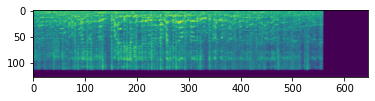

In [ ]:
plt.imshow(spec)

In [ ]:
#Test specs
for row in tqdm(sub.values):
  sound_path = row[-2] #this corresponds to 'file_name'
  spec_name = row[-1] #this corresponds to 'spec_name'

  spec = melspectogram_dB(sound_path, 15)
  spec = spec_to_image(spec)
  save_spec_image(spec, spec_name)

  0%|          | 0/12405 [00:00<?, ?it/s]

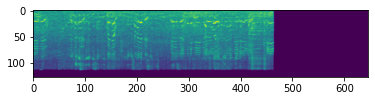

In [ ]:
plt.imshow(spec)

# **Save the Specs**

In [ ]:
#This code zips the generated spec images
#!zip -r Spec_imgs_cst_15.zip Imgs

In [ ]:
finalDf_path = '/content/drive/MyDrive/NoiseClassificationChallenge/Final_DF/'
train.to_csv(f'{finalDf_path}final_train.csv',index=False)
sub.to_csv(f'{finalDf_path}final_test.csv',index=False)

# **Modelling**

In [ ]:
finalDf_path = '/content/drive/MyDrive/NoiseClassificationChallenge/Final_DF/'
train = pd.read_csv(f'{finalDf_path}final_train.csv')
sub = pd.read_csv(f'{finalDf_path}final_test.csv')

In [ ]:
category = list(train["category"].unique())
category

In [ ]:
n_folds = 10
train['fold'] = 0

fold = StratifiedKFold(n_splits = n_folds, random_state=seed, shuffle = True)
for i, (tr, vr) in enumerate(fold.split(train, train['label'])):
  train.loc[vr, 'fold'] = i

In [ ]:
epochs = 15
device = 'cuda'
size = (300, 230)
arch='resnet34'
fc_size = 512
bs = 8
lr = 1e-4

In [ ]:
avg_logloss = 0
best_fold = 0
fold_logloss = np.inf

for fold in range(n_folds):
  _fold_logloss = run_fold(fold, size=size, arch=arch, fc_size=fc_size, lr=lr, bs=bs)
  avg_logloss += _fold_logloss

  if fold_logloss > _fold_logloss: best_fold = fold

print()
print("Avg LogLoss: ", avg_logloss/n_folds)

# **Loading models**

In [ ]:
MODELS = []
for i in range(n_folds):
  MODELS.append( AudioModel(arch_name=arch, fc_size=fc_size) )
  MODELS[i].to(device)
  MODELS[i].load_state_dict(torch.load(f'/content/drive/MyDrive/NoiseClassificationChallenge/MODELS/model_state_dict_{i}.bin'))
  MODELS[i].eval()

# **Prediction**

In [ ]:
predictions_labels, predictions_proba = predict(sub, size=size, bs=2)

# **Making a submission**

In [ ]:
submission = pd.DataFrame()
submission['ID'] = sub['ID']
for i, label in enumerate(category):
  submission[label] = 0
for i, label in enumerate(category):
  submission.loc[:,label] = np.array(predictions_proba)[:,i]

In [ ]:
submission.head()

In [ ]:
submission.to_csv(f'FinalSubmission.csv', index=False)